In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Get mnist, I guess (not using Keras)

import torch
import torch.nn.functional as F
import torchvision

from embedders.manifolds import ProductManifold
from embedders.vae import ProductSpaceVAE

mnist = torchvision.datasets.MNIST("./data", download=True)

In [3]:
# Torch device management
import torch

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [4]:
mnist.data.shape

torch.Size([60000, 28, 28])

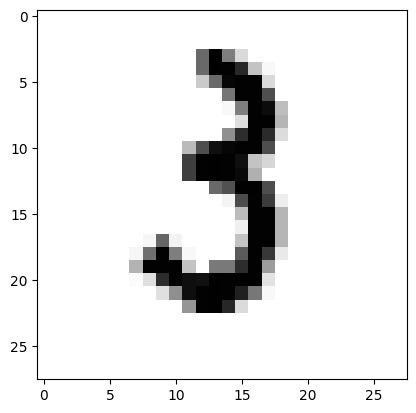

In [5]:
import matplotlib.pyplot as plt

plt.imshow(mnist.data[1234].detach().numpy(), cmap="gray_r")

In [6]:
class Encoder(torch.nn.Module):
    def __init__(self, pm):
        super().__init__()
        self.pm = pm
        self.fc1 = torch.nn.Linear(28 * 28, 256)
        self.fc3_z_mean = torch.nn.Linear(256, pm.dim)  # Use ambient dim
        self.fc3_z_logvar = torch.nn.Linear(256, pm.dim)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        z_mean_tangent = self.fc3_z_mean(h1)
        z_logvar = self.fc3_z_logvar(h1)

        z_mean = pm.manifold.expmap(x=pm.mu0, u=z_mean_tangent @ pm.projection_matrix)

        return z_mean, z_logvar


class Decoder(torch.nn.Module):
    def __init__(self, pm):
        super().__init__()
        self.pm = pm
        self.fc1 = torch.nn.Linear(pm.ambient_dim, 256)
        # self.fc2 = torch.nn.Linear(64, 256)
        self.fc3 = torch.nn.Linear(256, 28 * 28)

    def forward(self, z):
        h1 = F.relu(self.fc1(z))
        # h2 = F.relu(self.fc2(h1))
        x_recon = torch.sigmoid(self.fc3(h1))

        return x_recon

In [8]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

SIGNATURE = [(-1, 16), (0, 16), (1, 16)]
BATCH_SIZE = 64
N_EPOCHS = 5
LR = 1e-5
BETA = 0.1
N_SAMPLES = 32
CLIP_GRAD = False

# Manifold stuff
# pm = ProductManifold([(-1, 2), (0, 2), (1, 2)])
pm = ProductManifold(SIGNATURE)
vae = ProductSpaceVAE(
    product_manifold=pm, encoder=Encoder(pm), decoder=Decoder(pm), beta=BETA, n_samples=N_SAMPLES, device=device
)

# Training stuff
X_train = mnist.data.float().view(-1, 28 * 28) / 255.0
opt = torch.optim.Adam(vae.parameters(), lr=LR)

# Visualization stuff
my_tqdm = tqdm(total=N_EPOCHS * len(X_train))

# Device stuff
vae = vae.to(device)
X_train = X_train.to(device)
pm = pm.to(device)


# Gradient checking stuff
def grads_ok(vae):
    out = True
    for name, param in vae.named_parameters():
        if param.grad is not None:
            if torch.isnan(param.grad).any():
                print(f"NaN gradient in {name}")
                out = False
            if torch.isinf(param.grad).any():
                print(f"Inf gradient in {name}")
                out = False
    return out


L = torch.nn.MSELoss(reduction="none")
for epoch in range(N_EPOCHS):
    # opt.param_groups[0]["lr"] = lr
    for i in range(0, len(X_train), BATCH_SIZE):
        x_batch = X_train[i : i + BATCH_SIZE]

        elbo, ll, kl = vae.elbo(x_batch)
        loss = -elbo

        opt.zero_grad()
        loss.backward()

        # Gradient clipping
        if CLIP_GRAD:
            torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.0)
        if torch.isnan(loss):
            print(f"Loss is NaN at iteration {i}")
        elif torch.isinf(loss):
            print(f"Loss is inf at iteration {i}")
        elif grads_ok(vae):
            opt.step()

        # if i % 100 * BATCH_SIZE == 0:
        #     z_mean, z_sigma = vae.encoder(x_batch)
        #     my_tqdm.set_postfix({"Example latent": ", ".join([f"{x:.2f}" for x in z_mean[0]])})

        my_tqdm.update(BATCH_SIZE)
        my_tqdm.set_description(f"Epoch {epoch}, loss: {loss.item():.1f}, ll: {ll.item():.1f}, kl: {kl.item():.1f}")

  0%|          | 0/300000 [00:00<?, ?it/s]

z mean variance: 0.7404361367225647
z logvar variance: 13.457897186279297
x_recon variance: 0.052793435752391815


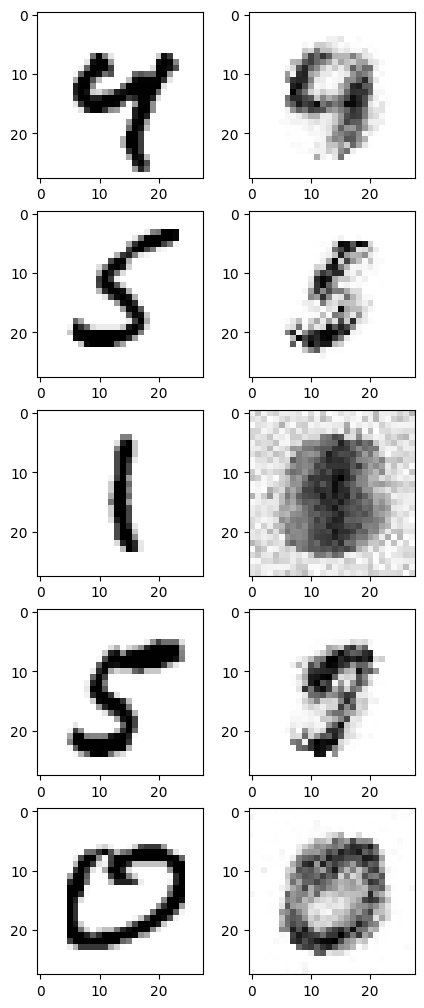

In [9]:
# Let's try a reconstruction
N_RECONSTRUCTIONS = 5

x = X_train[torch.randint(low=0, high=len(X_train), size=(N_RECONSTRUCTIONS,))]
x_recon, z_mean, sigma = vae(x.view(-1, 28 * 28))

fig, axs = plt.subplots(N_RECONSTRUCTIONS, 2, figsize=(5, 5 * N_RECONSTRUCTIONS / 2))
for i in range(N_RECONSTRUCTIONS):
    axs[i, 0].imshow(x[i].view(28, 28).detach().cpu().numpy(), cmap="gray_r")
    axs[i, 1].imshow(x_recon[i].view(28, 28).detach().cpu().numpy(), cmap="gray_r")

print(f"z mean variance: {z_mean.var(dim=0).mean().item()}")
print(f"z logvar variance: {sigma.var(dim=0).mean().item()}")
print(f"x_recon variance: {x_recon.var().item()}")

In [ ]:
z_logvar.exp()

tensor([[[3.5733e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         [1.0000e+00, 5.3354e+02, 1.0000e+00,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.9099e+00,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         ...,
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 3.5696e+01,
          1.0000e+00, 1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
          1.1972e+00, 1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
          1.0000e+00, 1.1346e+00]],

        [[3.6516e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         [1.0000e+00, 1.8000e+03, 1.0000e+00,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.8901e+00,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         ...,
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 6.7089e+01,
          1.000

In [ ]:
_x = torch.repeat_interleave(torch.Tensor([[1], [2], [3]]), dim=0, repeats=5)
_x.view(-1, 5).mean(dim=1)

tensor([1., 2., 3.])